In [ ]:
pip install momentfm

In [ ]:
# alternative
!pip install git+https://github.com/moment-timeseries-foundation-model/moment.git

In [ ]:
!pip install numpy pandas scikit-learn matplotlib tqdm

In [4]:
# getting the MOMENT model 
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={'task_name': 'embedding'}, # We are loading the model in `embedding` mode to learn representations
    local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [6]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [8]:
# Number of parameters in the encoder
num_params = sum(p.numel() for p in model.encoder.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 341231104


In [10]:
# import NHANES data 
import torch
import pandas as pd

df = pd.read_csv("data/data_wide.csv", index_col=0)
df.head(3)

,seqn,gender,age,race,education,married,pir,bmi,time1,time2,...,time2007,time2008,time2009,time2010,time2011,time2012,time2013,time2014,time2015,time2016
1,21009,1,55,3,3,1,3.79,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21010,2,52,3,4,6,1.24,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,21012,1,63,4,3,6,0.89,0,1,0,...,1,1,0,0,0,1,1,0,0,0


In [12]:
# reshaping the data with L2 normalization 
import numpy as np

def normalize_l2(x):
    x = np.array(x)
    if x.ndim == 1:
        norm = np.linalg.norm(x)
        if norm < 1e-10:  # Use a small threshold instead of exact zero
            return x
        return x / norm
    else:
        # Create a copy of x to store the result
        normalized = np.zeros_like(x, dtype=np.float64)
        
        # Calculate norms for each row
        norms = np.linalg.norm(x, 2, axis=1, keepdims=True)
        
        # Process each row separately, avoiding division by zero
        for i in range(x.shape[0]):
            if norms[i] >= 1e-10:  # Only normalize if norm is not effectively zero
                normalized[i] = x[i] / norms[i]
            else:
                normalized[i] = x[i]  # Keep original values if norm is effectively zero
                
        return normalized

def prepare_data_from_df(df, value_columns, n_channels=1):
    MAX_SEQ_LEN = 512
    
    # convert time series columns to numpy array
    data = df[value_columns].values
    n_batchsize, n_context = data.shape
    print(f"Original data shape: {data.shape}")
    
    # confirm the reshaping
    context_per_channel = n_context // n_channels
    if n_context % n_channels != 0:
        raise ValueError(f"Number of features ({n_context}) must be divisible by number of channels ({n_channels})")
    
    # check if sequence length is greater than max=512 and truncate if needed.
    if context_per_channel > MAX_SEQ_LEN:
        print(f"Warning: Context length per channel ({context_per_channel}) exceeds maximum of {MAX_SEQ_LEN}. "
              f"Truncating to {MAX_SEQ_LEN}.")
        new_n_context = n_channels * MAX_SEQ_LEN
        data = data[:, :new_n_context]
        context_per_channel = MAX_SEQ_LEN
    
    # Apply L2 normalization to the data
    data = normalize_l2(data)
    
    # reshape the data into [batchsize, channel, context]
    data_reshaped = data.reshape(n_batchsize, n_channels, context_per_channel)
    print(f"Reshaped data shape: {data_reshaped.shape}")
    
    # Convert to torch tensor
    data_tensor = torch.FloatTensor(data_reshaped)
    print(f"Tensor shape: {data_tensor.shape}")
    
    return data_tensor  # [batchsize, channel, context_length]

In [14]:
value_columns = [col for col in df.columns if col.startswith('time')]
data_tensor = prepare_data_from_df(df, value_columns, n_channels=1)

Original data shape: (6943, 2016)
Reshaped data shape: (6943, 1, 512)
Tensor shape: torch.Size([6943, 1, 512])


In [ ]:
###### DONT RUN. embedding of the data 
from pprint import pprint

output = model(x_enc=data_tens or)
pprint(output)

In [ ]:
##### DONT RUN: get 3500 random subset from the data_tensor
import random

np.random.seed(1)
random_indices = random.sample(range(data_tensor.shape[0]), 3500)
subset_data = data_tensor[random_indices]

print(f"Subset shape: {subset_data.shape}")   

In [16]:
# get two chunks of subset 
subset_data1 = data_tensor[:3500]
subset_data2 = data_tensor[3500:]

print(f"Subset shape: {subset_data1.shape}")
print(f"Subset shape: {subset_data2.shape}")

Subset shape: torch.Size([3500, 1, 512])
Subset shape: torch.Size([3443, 1, 512])


In [18]:
# embedding of the subset1
from pprint import pprint

output1 = model(x_enc=subset_data1)
pprint(output1)

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TimeseriesOutputs(forecast=None,
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embeddings=tensor([[-6.1375e-02,  3.6880e-02, -3.4403e-02,  ..., -4.6302e-02,
          4.6088e-02, -1.6446e-02],
        [-3.1172e-02,  6.5116e-02, -5.4463e-02,  ..., -7.8727e-02,
          6.1699e-02,  3.5700e-02],
        [-5.1081e-02,  9.4605e-03, -1.8195e-02,  ..., -1.3899e-02,
          3.0584e-02, -4.9600e-03],
        ...,
        [-9.4022e-03,  4.5657e-03, -5.0111e-02,  ..., -7.7092e-02,
          6.9535e-02, -1.8906e-02],
        [-5.8016e-02,  4.7004e-02, -3.8945e-02,  ..

In [20]:
# extract embedding results of subset1
embeddings1 = output1.embeddings
embeddings1_np = embeddings1.detach().cpu().numpy()
 
# convert to dataframe 
embeddings1_df = pd.DataFrame(embeddings1_np)

# combine with columns up to 'bmi' from the original dataset 
df_subset1 = df.iloc[:3500].reset_index(drop=True)
embeddings1_df = pd.concat([pd.DataFrame(embeddings1_np), df_subset1.loc[:, :'bmi']], axis=1)

# reorder columns 
original_cols1 = df_subset1.loc[:, :'bmi'].columns.tolist()
embeddings1_cols = list(range(embeddings1_np.shape[1])) 
embeddings1_df = embeddings1_df[original_cols1 + embeddings1_cols]

embeddings1_df.index = range(1, len(embeddings1_df) + 1)

embeddings1_df.head()

,seqn,gender,age,race,education,married,pir,bmi,0,1,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
1,21009,1,55,3,3,1,3.79,1,-0.061375,0.036880,...,-0.023566,0.015983,-0.034984,0.008483,-0.020223,-0.023411,-0.022229,-0.046302,0.046088,-0.016446
2,21010,2,52,3,4,6,1.24,1,-0.031172,0.065116,...,-0.054518,0.012035,-0.033737,0.021556,-0.010112,0.000372,-0.038126,-0.078727,0.061699,0.035700
3,21012,1,63,4,3,6,0.89,0,-0.051081,0.009460,...,0.009530,0.029781,-0.062735,-0.006267,-0.008770,-0.003090,-0.017836,-0.013899,0.030584,-0.004960
4,21015,1,83,3,4,1,1.20,1,-0.069653,0.025378,...,-0.015907,0.015356,-0.036152,-0.030555,-0.009143,0.016224,-0.039778,-0.028832,0.048463,-0.036006
5,21017,2,37,1,2,6,0.21,0,-0.058702,0.023075,...,-0.073520,0.032745,-0.035278,0.031491,-0.051431,0.000071,-0.026822,-0.056032,0.065263,0.011862


In [22]:
# save embeddings of subset1
embeddings1_df.to_csv("./data/embeddings_moment_subset1_1024.csv")

In [24]:
# reducing dimension of subset1 to 50 

def reduce_dimension(embedding, dim=50):
    return embedding[:, :dim]
reduced_embeddings1_np = reduce_dimension(embeddings1_np)

# convert to dataframe 
red_embeddings1_df = pd.DataFrame(reduced_embeddings1_np)
red_embeddings1_df = pd.concat([pd.DataFrame(reduced_embeddings1_np), df_subset1.loc[:, :'bmi']], axis=1)

original1_cols = df_subset1.loc[:, :'bmi'].columns.tolist()
embedding1_cols = list(range(reduced_embeddings1_np.shape[1])) 
red_embeddings1_df = red_embeddings1_df[original1_cols + embedding1_cols]
red_embeddings1_df.index = range(1, len(red_embeddings1_df) + 1)

red_embeddings1_df.head()

,seqn,gender,age,race,education,married,pir,bmi,0,1,...,40,41,42,43,44,45,46,47,48,49
1,21009,1,55,3,3,1,3.79,1,-0.061375,0.036880,...,0.016373,0.017987,-0.020101,0.018005,-0.035890,-0.881681,-0.086510,-0.130371,-0.002952,-0.044264
2,21010,2,52,3,4,6,1.24,1,-0.031172,0.065116,...,-0.032176,0.008067,-0.028855,-0.038687,-0.076404,-0.867669,-0.080844,-0.094918,0.008938,-0.025150
3,21012,1,63,4,3,6,0.89,0,-0.051081,0.009460,...,0.010053,-0.006117,0.000734,0.019278,-0.029963,-0.845656,-0.067871,-0.133935,-0.015950,-0.029622
4,21015,1,83,3,4,1,1.20,1,-0.069653,0.025378,...,0.030447,0.038635,-0.025715,0.032448,-0.035835,-0.797379,-0.077107,-0.171770,-0.016446,-0.045090
5,21017,2,37,1,2,6,0.21,0,-0.058702,0.023075,...,0.007615,0.042566,-0.035541,0.028672,-0.066332,-0.868069,-0.044714,-0.143913,0.014318,-0.007508


In [26]:
# save embeddings with dimension reduction 
red_embeddings1_df.to_csv("./data/embeddings_moment_subset1_50.csv")

In [28]:
# embedding of the subset2
from pprint import pprint

output2 = model(x_enc=subset_data2)
pprint(output2)

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TimeseriesOutputs(forecast=None,
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embeddings=tensor([[-0.0550,  0.0400, -0.0481,  ..., -0.0404,  0.0455, -0.0380],
        [-0.0359,  0.0193, -0.0406,  ..., -0.0862,  0.0713, -0.0002],
        [-0.0250,  0.0239, -0.0192,  ..., -0.0529,  0.0415, -0.0261],
        ...,
        [-0.0615, -0.0107, -0.0376,  ..., -0.0081,  0.0572, -0.0397],
        [-0.0341,  0.0167, -0.0480,  ..., -0.0439,  0.0328, -0.0374],
        [-0.0525,  0.0176, -0.0418,  ..., -0.0206,  0.0385,  0.0292]]),
                  metadata='mean',
      

In [38]:
# extract embedding results for second subset
embeddings2 = output2.embeddings
embeddings2_np = embeddings2.detach().cpu().numpy()
 
# convert to dataframe 
embeddings2_df = pd.DataFrame(embeddings2_np)

# combine with columns up to 'bmi' from the original dataset 
df_subset2 = df.iloc[3500:].reset_index(drop=True)
embeddings2_df = pd.concat([pd.DataFrame(embeddings2_np), df_subset2.loc[:, :'bmi']], axis=1)

# reorder columns 
original2_cols = df_subset2.loc[:, :'bmi'].columns.tolist()
embeddings2_cols = list(range(embeddings2_np.shape[1])) 
embeddings2_df = embeddings2_df[original2_cols + embeddings2_cols]

embeddings2_df.index = range(1, len(embeddings2_df) + 1)

embeddings2_df.head()

,seqn,gender,age,race,education,married,pir,bmi,0,1,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
1,31183,2,33,3,5,1,3.90,1,-0.055011,0.039953,...,-0.074217,-0.022236,-0.036040,0.023753,0.007128,-0.036365,-0.013751,-0.040431,0.045520,-0.037951
2,31186,2,46,1,1,3,1.68,1,-0.035945,0.019263,...,-0.030063,0.008317,-0.045595,-0.010246,-0.030636,-0.023607,-0.031996,-0.086167,0.071279,-0.000200
3,31187,2,22,3,4,6,4.29,1,-0.024960,0.023898,...,-0.032067,0.013064,-0.036885,-0.004430,-0.022011,-0.014765,-0.031623,-0.052872,0.041466,-0.026117
4,31194,2,47,1,1,3,1.02,1,-0.039385,0.047492,...,-0.036413,0.025165,-0.063565,0.029113,-0.045179,-0.027492,-0.020567,-0.053423,0.059044,0.000596
5,31195,1,73,3,4,1,5.00,0,-0.046546,0.026695,...,-0.031783,0.011810,-0.052689,-0.017665,-0.020827,-0.023144,-0.007389,-0.059902,0.054974,-0.015622


In [42]:
# reducing dimension for subset2
def reduce_dimension(embedding, dim=50):
    return embedding[:, :dim]
reduced_embeddings2_np = reduce_dimension(embeddings2_np)

# convert to dataframe 
red_embeddings2_df = pd.DataFrame(reduced_embeddings2_np)
red_embeddings2_df = pd.concat([pd.DataFrame(reduced_embeddings2_np), df_subset2.loc[:, :'bmi']], axis=1)

original2_cols = df_subset2.loc[:, :'bmi'].columns.tolist()
embedding2_cols = list(range(reduced_embeddings2_np.shape[1])) 
red_embeddings2_df = red_embeddings2_df[original2_cols + embedding2_cols]
red_embeddings2_df.index = range(1, len(red_embeddings2_df) + 1)

red_embeddings2_df.head()

,seqn,gender,age,race,education,married,pir,bmi,0,1,...,40,41,42,43,44,45,46,47,48,49
1,31183,2,33,3,5,1,3.90,1,-0.055011,0.039953,...,0.044968,0.041012,-0.004977,0.017510,-0.047604,-0.740984,-0.065554,-0.168065,-0.018086,-0.036968
2,31186,2,46,1,1,3,1.68,1,-0.035945,0.019263,...,0.024751,0.019362,-0.038653,0.010897,-0.060261,-0.859908,-0.084964,-0.084851,0.004536,-0.048224
3,31187,2,22,3,4,6,4.29,1,-0.024960,0.023898,...,0.003397,0.028877,-0.019058,-0.022575,-0.050082,-0.916767,-0.077313,-0.148370,-0.013513,-0.022824
4,31194,2,47,1,1,3,1.02,1,-0.039385,0.047492,...,-0.019135,0.017536,-0.026117,0.025634,-0.048371,-0.864587,-0.067891,-0.099167,0.001687,-0.037764
5,31195,1,73,3,4,1,5.00,0,-0.046546,0.026695,...,0.013865,-0.003344,0.024455,0.035110,-0.054572,-0.821886,-0.078766,-0.111349,0.016212,-0.050051


In [40]:
# save embeddings2
embeddings2_df.to_csv("./data/embeddings_moment_subset2_1024.csv")

In [46]:
# save embeddings with dimension reduction for subset 2
red_embeddings2_df.to_csv("./data/embeddings_moment_subset2_50.csv")

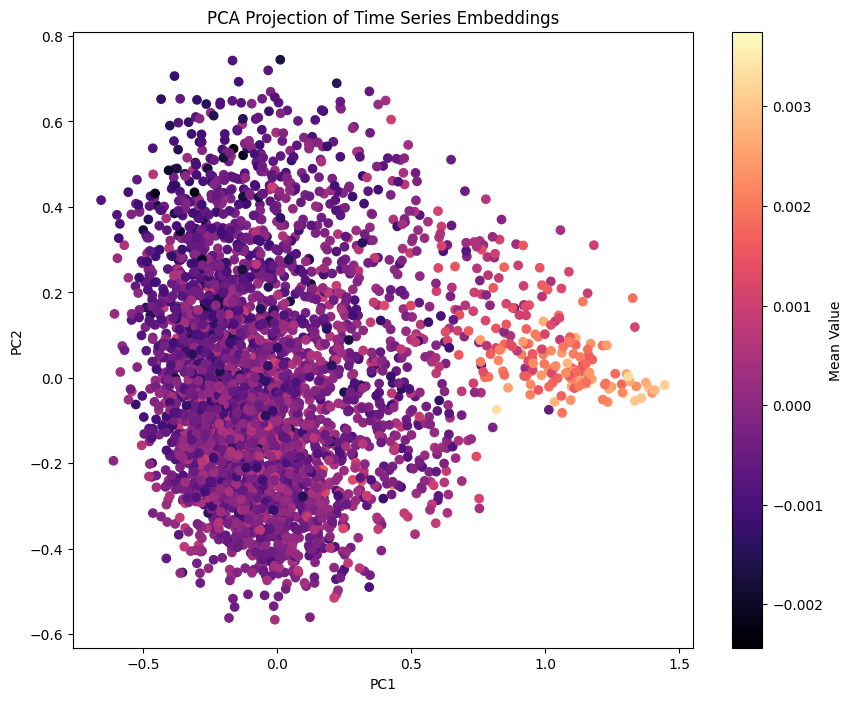

In [52]:
# PCA on the embeddings of subset1
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

embeddings1_manifold = PCA(n_components=2).fit_transform(embeddings1_np)
c = np.mean(embeddings1_np, axis=1)
categorical = False

plt.figure(figsize=(10, 8))
plt.scatter(
    embeddings1_manifold[:, 0],
    embeddings1_manifold[:, 1],
    c=c,
    cmap='magma'
)
plt.colorbar(label='Mean Value' if not categorical else 'Subject ID')
plt.title('PCA Projection of Time Series Embeddings')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()